#  🐶 End-to-end Multi-class Dog Breed Classification

This notebook builds an end-to-end multi-class image classifier using TensorFlow 2.0 and TensorFlow Hub.

## 1. Problem
Identiifying the breeds of a dog given an imahe of a dog.

When I'm going on streets and I take a photo of a dog, I want to know what breed of dog it is.

## 2. Data
The data we're using is from Kaggle's dog breed identification competition.

https://www.kaggle.com/competitions/dog-breed-identification/data

## 3. Evaluation
The evaluation is a file with prediction probabilities for each dog of each test image.

https://www.kaggle.com/competitions/dog-breed-identification/overview/evaluation

## 4. Features
 Some informations about the data:
 * We're dealing with images (unstructured data) so itis probably best we use deep learning/transfer learning.
 * There are 120 breed of dogs (this means there are 120 different classes).
 * There are around 10,000+ images in the training set (these images have labels).
 * There are around 10,000+ images in the test set (these images have no labels, because we'll want to predict them)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Unzip the zip data file
# !unzip "drive/MyDrive/Dog Vision/dog-breed-identification.zip" -d "drive/MyDrive/Dog Vision/"

### Get Our workspace ready

* Import TensorFlow 2✅
* Import TensorFlow Hub✅
* Make sure we're using a GPU✅

In [ ]:
# Import necessary tools
import tensorflow as tf
import tensorflow_hub as hub
print("TF version:", tf.__version__)
print("TF Hub version:", hub.__version__)

# Check for GPU availability
print("GPU", "available (YESS!)" if tf.config.list_physical_devices("GPU") else "not available :(")

TF version: 2.12.0
TF Hub version: 0.14.0
GPU available (YESS!)


## Getting our data ready (truning  into Tensors)

With learning models, our data has to be in numerical format. So that's what we'll be doing first. Turning our images into Tensors (numerical representations).

Let's start by accessing our data and checking out the labels.

In [ ]:
# Checkout the labels of our data
import pandas as pd
labels_csv = pd.read_csv("drive/MyDrive/Dog Vision/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [ ]:
labels_csv.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

<Axes: >

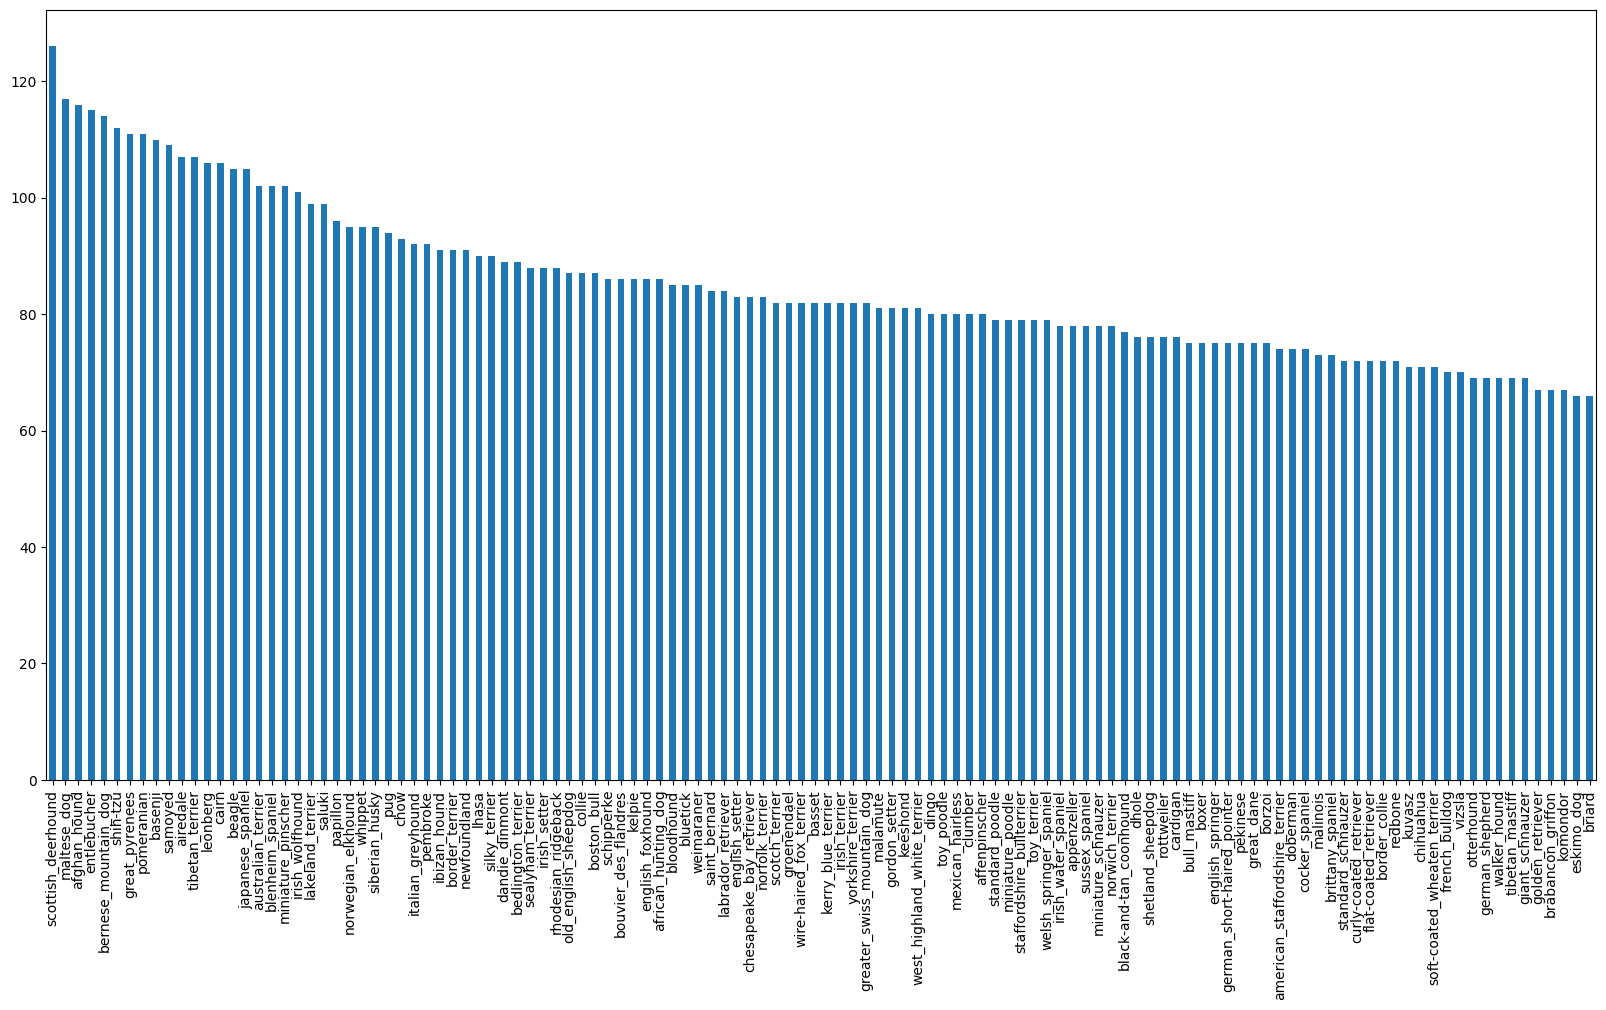

In [ ]:
# How many images are there of each breed?
labels_csv["breed"].value_counts().plot.bar(figsize = (20, 10))

In [ ]:
labels_csv["breed"].value_counts().median()

82.0

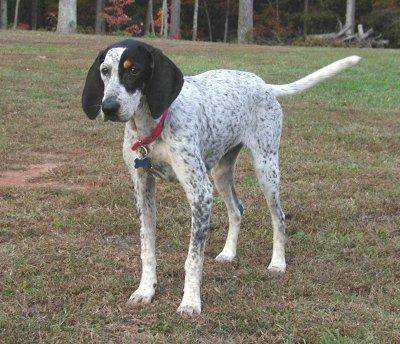

In [ ]:
# Let's view an image
from IPython.display import Image
Image("drive/MyDrive/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg")

### Getting images and their labels
 Let's get a list of all our image file pathnames

In [ ]:
labels_csv.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

In [ ]:
# Create pathnames from images ID's
filenames = ["drive/MyDrive/Dog Vision/train/" + fname + ".jpg" for  fname in labels_csv["id"]]

# Check the first 10 file names
filenames[:10]

['drive/MyDrive/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/MyDrive/Dog Vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/MyDrive/Dog Vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/MyDrive/Dog Vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/MyDrive/Dog Vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/MyDrive/Dog Vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [ ]:
# Check whether number of file names matches number of image files
import os
if len(os.listdir("drive/MyDrive/Dog Vision/train/")) == len(filenames):
  print("Filenames match actual number of files! Proceed")
else:
  print("Filename doesn't match actual number of files, check the target directory!")

Filenames match actual number of files! Proceed


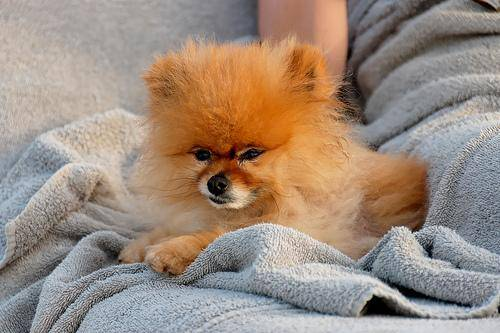

In [ ]:
# One more check
Image(filenames[8000])

In [ ]:
labels_csv["breed"][8000]

'pomeranian'

In [ ]:
type(filenames)

list

Since we've now got our training image filepaths in a list, let's prepare our labels.

In [ ]:
import numpy as np
labels = labels_csv["breed"].to_numpy()
# labels = np.array(labels) # Does same thing as above
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [ ]:
len(labels)

10222

In [ ]:
# See if number of labels matches the number of filenames
if len(labels) == len(filenames):
  print("Number of labels matches number of filenames!")
else:
  print("Number of labels doesn't matches number of filenames. Check data diretctories!")

Number of labels matches number of filenames!


In [ ]:
# Find the unique label values
unique_breeds = np.unique(labels)
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [ ]:
len(unique_breeds)

120

In [ ]:
# Turn a single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [ ]:
# Turn every label into a boolean array
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [ ]:
labels[1]

'dingo'

In [ ]:
len(boolean_labels)

10222

In [ ]:
# Example: Turning boolean array into integers
print(labels[0]) # original label
print(np.where(unique_breeds == labels[0])) # index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # there will be a 1 where the sample label occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [ ]:
print(labels[2])
print(boolean_labels[2].astype(int))

pekinese
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [ ]:
filenames[:2]

['drive/MyDrive/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg']

In [ ]:
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

### Creating our own Validation set

Since the dataset from Kaggle doesn't come with a Validation set, we're going to create our own.

In [ ]:
# Setup X and y variables
X = filenames
y = boolean_labels

In [ ]:
len(filenames)

10222

we're going to start off experimenting with ~1000 imaegs and increase as needed..

In [ ]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000, step:1000}

In [ ]:
# Lets split our data into traina and validation sets
from sklearn.model_selection import train_test_split

# Split them into training and validation of total size NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES], y[:NUM_IMAGES], test_size = 0.2, random_state = 42)

len(X_train), len(X_val), len(y_train), len(y_val)

(800, 200, 800, 200)

In [ ]:
# Lets have a geez at training data
X_train[:2], y_train[:2]

(['drive/MyDrive/Dog Vision/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/MyDrive/Dog Vision/train/0d2f9e12a2611d911d91a339074c8154.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, Fal

## Preprocessing Images (turning images into Tensors)

To preprocess our images into Tensors we're going to write a function which does a  few things:
1. Take an image filepath as input
2. Use TensorFlow to read file and save it to a variable, `image`
3. Turn ou`image` (a jpg) into Tensors
4. Resize the `image` to be a shape of (224, 224)
5. Return the modified `image`

## Before we do, lets see what importing an image looks like...

In [ ]:
# Convert an image into Numpy array
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

In [ ]:
image[:2]

array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]]], dtype=uint8)

In [ ]:
# Turn image into Tensors
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  89],
        [ 76, 124,  76],
        [ 63, 111,  61],
        ...,
        [ 77, 133,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  75],
        [ 67, 114,  68],
        [ 63, 110,  64],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 132,  84]]], dtype=uint8)>

In [ ]:
image.max(), image.min()

(255, 0)

Now we've  seen what an image looks like as a Tensor, let's make a function to preprocess  them.

1. Take an image filepath as input
2. Use TensorFlow to read file and save it to a variable, `image`
3. Turn our `image` (a jpg) into Tensors
4. Normallize our image (convert colour channel values to 0-255 to 0-1)
5. Resize the `image` to be a shape of (224, 224)
6. Return the modified `image`

In [ ]:
# Define image size
IMG_SIZE = 224

# Create a function for preprocessing images
def process_image(image_path, img_size = IMG_SIZE):
  """
  Take an image file path and turns the image into a Tensor.
  """
  # Read in an image file
  image = tf.io.read_file(image_path)
  # Turn jpg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # convert the colour channel values to from 0-255 to  0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired value (224, 224)
  image = tf.image.resize(image, size = [img_size, img_size])

  return image

In [ ]:
# tensor = tf.io.read_file(filenames[2])
# tensor

In [ ]:
# tensor = tf.image.decode_jpeg(tensor, channels=3)

In [ ]:
# tf.image.convert_image_dtype(tensor, tf.float32)

##  Turning our data into branches

Why turn our data into batches?

Let's say you're trying to process 10,000+ images in one go...they'll might not fit into memeory.

So that's why we do about 32 (this is batch size) images at a time (you can manually adjust the bath size if need be).

in order to use TensorFlow effectively, we need our data in the form of Tensor tuple which looks like this: `(image, labels)`

In [ ]:
# Create a simple function to create a tuple (image, labels)
def get_image_label(image_path, label):
   """
   Takes an image file path name and the associated label,
   processes the image and returns a tuple if (image, label).
   """

   image = process_image(image_path)
   return image, label

In [ ]:
# Demo of the above
(process_image(X[42]), tf.constant(y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

Now we've got a wa to turn our data into tuples of Tensors in the form `(image, label)`, lets make a function to turn all of our data(X and y) into batches.

In [ ]:
# Define the batch size, 32 is a good size
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(X, y = None, batch_size = BATCH_SIZE, valid_data = False, test_data = False):
  """
  Create batches of data out of image (X) and label (y) pairs.
  Shuffles the data if it's training data but deosn't shuffles if it's validation data.
  Also accepts test data as input (no labels)
  """
  # If the data is a test dataset, we probably don't have labels
  if test_data:
    print("Creating test data batches....")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # only filepaths (no labels)
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  # If the data is a valid dataset, we don't need to shuffle it
  if valid_data:
    print("Creating validation data batches....")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),  # filepaths
                                               tf.constant(y)))  #  labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    print("Creating training data batches....")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))

    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size = len(X))

    # Create (image, label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the training data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch


In [ ]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data = True)

Creating training data batches....
Creating validation data batches....


In [ ]:
# Check out the diff attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualizing data batches

Our data is now in batche, however, these can be little hard to understand/comprehaend, let's visualize them!

In [ ]:
import matplotlib.pyplot as plt

# Create a function for viewing  images in a data batch
def show_25_images(images, labels):
  """
  Displays a plot of 25 images and their labels from a data batch
  """
  # Setup the fugure
  plt.figure(figsize = (10,10))
  # Loop through 25 (for displaying 25 images)
  for i in range(25):
    # Create subplots
    ax = plt.subplot(5, 5, i+1)
    # Display an image
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    # turn the grid lines off
    plt.axis("off")

In [ ]:
train_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

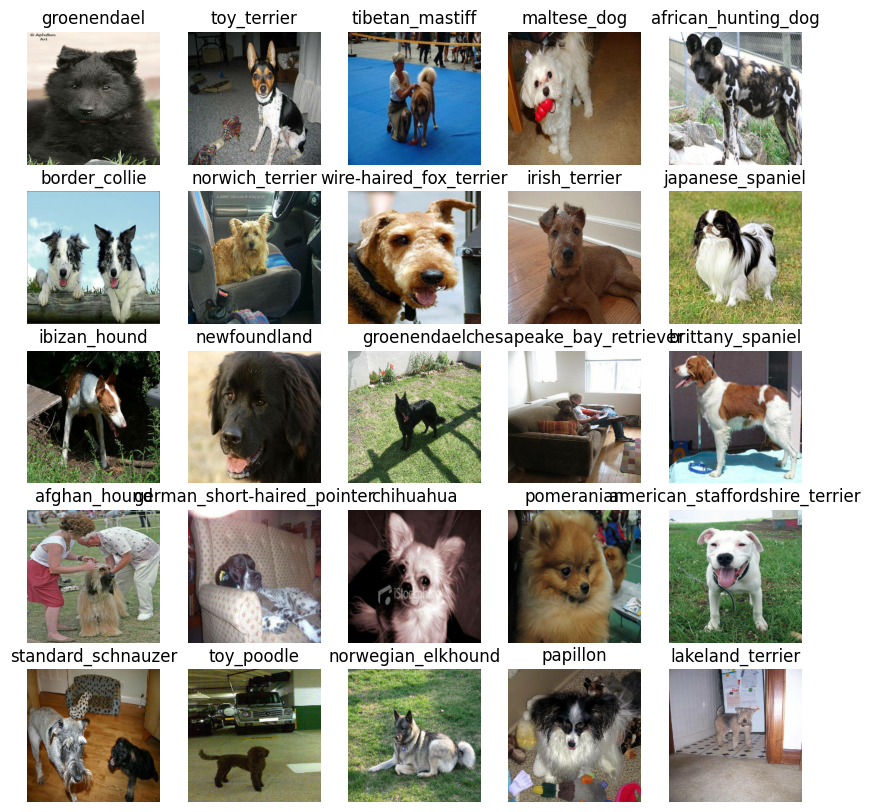

In [ ]:
# Now let's visualize the data  in training batch
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

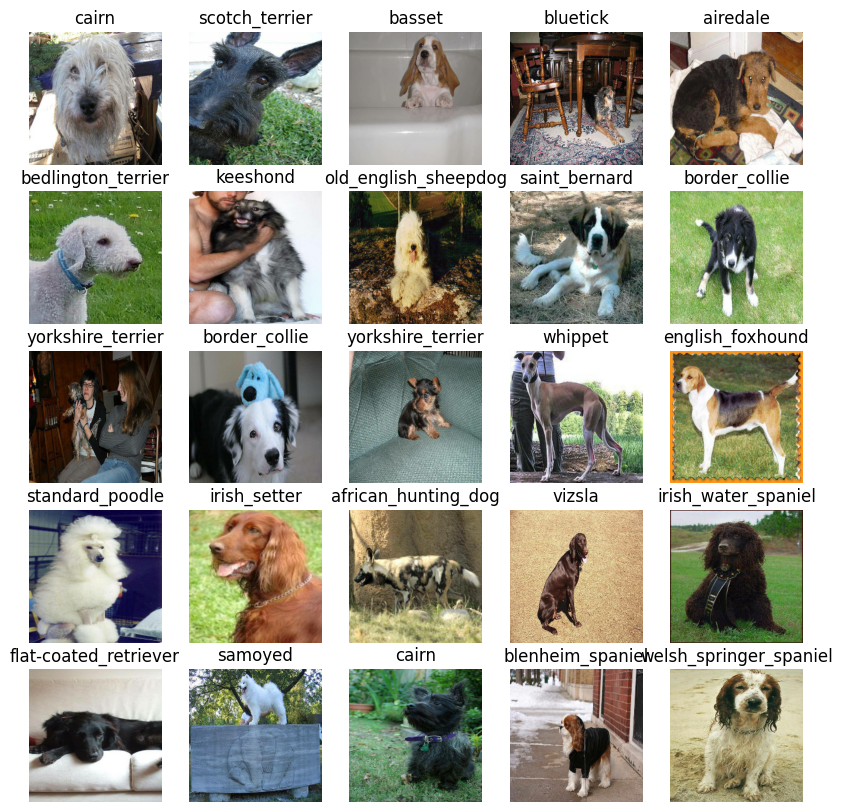

In [ ]:
# Now let's visualize our validation set
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

## Building a Model

Before we build a model, there are a few things  we need to define:
* The input shape (our images shape, in the form of Tensors) to our model.
* The output shape ( image labels in the form of Tensors) of our model.
* The URL of the model we want to use from TensorFlow Hub:
https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5

In [ ]:
IMG_SIZE

224

In [ ]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, colour channels

# Setup output shape of our model
OUTPUT_SHAPE = len(unique_breeds)

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"


Now we've got our inputs, outputs and model ready to go.
Let's put them together into a Keras deep learning model!

Knowing this, let's create a function which:
* Takes the input shape, output shape and the model we've chosen as parameters.
* Defines the layers in a Keras model in sequential fashion (do this first, then this, then that).
* Compiles the model (says it should be evaluated and improved).
* Builds the model (tells the model the input shape it'll be  getting).
* Returns the model.

All of these steps can be found here:
https://www.tensorflow.org/guide/keras

In [ ]:
 # Create a function which buildsa a Keras model
def create_model(input_shape = INPUT_SHAPE, output_shape = OUTPUT_SHAPE, model_url = MODEL_URL):
  print("Building model with:", MODEL_URL)
  model = tf.keras.Sequential([
      hub.KerasLayer(MODEL_URL), # layer 1 (input layer)
      tf.keras.layers.Dense(units = OUTPUT_SHAPE,
                            activation = "softmax") # layer 2 (output layer)
  ])

  # Compile the model
  model.compile(
      loss = tf.keras.losses.CategoricalCrossentropy(),
      optimizer = tf.keras.optimizers.Adam(),
      metrics =  ["accuracy"]
  )

  # Build the model
  model.build(INPUT_SHAPE)

  return model

In [ ]:
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              5432713   
                                                                 
 dense (Dense)               (None, 120)               120240    
                                                                 
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


In [ ]:
outputs = np.ones(shape = (1,1,1280))
outputs

array([[[1., 1., 1., ..., 1., 1., 1.]]])

## Create callbacks

Callbacks are helper functons a model can use during training to do such things as save its progress, check its progress or stop training early if a model stops improving.

We'll create two callbacks, one for TensorBoard wich helps track out models progress and another for early stopping which prevents out model from training for too long.

### TenosorBoard Callbacks

To setup a TensorBoard callback, we need to do 3 things:
1. Load the TensorBoard notebook extension ✅
2. Create a TensorBoard callback which is able to save logs to a directory and passs it to our models's `fit()` function.✅
3. Visualize our models training logs with the `%tensorboard` magic function (well do this after model training).

In [ ]:
# Load TensorBoard notebook extension
%reload_ext tensorboard

In [ ]:
import datetime

# Create a function to build a tensorboard callback
def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join("drive/MyDrive/Dog Vision/logs",
                        # Make it so that the logs get tracked whenevr we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

### Early Stopping Callback

Early stopping helps stop our model from overfitting by stopping training if a certain evaluation metric stops improving.

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

In [ ]:
# Create early stopping callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3)

## Training a model (on subset of data)

Our first model is only going to train on 1000 images, to make aure everything is working

In [ ]:
NUM_EPOCHS = 100 #@param {type:"slider", min:10, max:100, step:10}

In [ ]:
# Check to make sure we're still running on a GPU
print("GPU", "Available (Yessss!)" if tf.config.list_physical_devices("GPU") else "not  available")


GPU Available (Yessss!)


Lets create a function which trains a model.

* Create a model using `create_model()`
* Setup a TensorBoard callback using `create_tensorboard_callback()`
* Call the `fit()` function on our model passing it the training data, validation data, number of  epochs to train for (`NUM_EPOCHS`) and the  callbacks we'd like to use
* Return the model

In [ ]:
# Build a function to train and return a trained model
def train_model():
  """
  Trains a given model and returns the trained model.
  """
  # Create a model
  model = create_model()

  # Create new TensorBoard session everytime we train a model
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data passing it the callbacks we created
  model.fit(x = train_data,
            epochs = NUM_EPOCHS,
            validation_data = val_data,
            validation_freq = 1,
            callbacks = [tensorboard, early_stopping])

  # Return the fitted model
  return model

In [ ]:
# Fit the model to the data
model = train_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Epoch 1/100
25/25 [==============================] - 122s 3s/step - loss: 4.4341 - accuracy: 0.1200 - val_loss: 3.3352 - val_accuracy: 0.2650
Epoch 2/100
25/25 [==============================] - 3s 123ms/step - loss: 1.5977 - accuracy: 0.6888 - val_loss: 2.0857 - val_accuracy: 0.5000
Epoch 3/100
25/25 [==============================] - 3s 134ms/step - loss: 0.5393 - accuracy: 0.9463 - val_loss: 1.6075 - val_accuracy: 0.6150
Epoch 4/100
25/25 [==============================] - 3s 129ms/step - loss: 0.2399 - accuracy: 0.9912 - val_loss: 1.4124 - val_accuracy: 0.6600
Epoch 5/100
25/25 [==============================] - 4s 146ms/step - loss: 0.1395 - accuracy: 0.9975 - val_loss: 1.3485 - val_accuracy: 0.6500
Epoch 6/100
25/25 [==============================] - 4s 161ms/step - loss: 0.0966 - accuracy: 1.0000 - val_loss: 1.3025 - val_accuracy: 0.6700
Epoch 7/100
25/25 [==============================]

***Question:*** It looks like our model is overfitting because its performing far better on the training data set than the validation data set,  what are some ways to prevent model overfitting in deep learning neural networks?

***Note:*** Overfitting to begin with is a good thing! it means our model is learning!

### Checking the TenosrBoard logs

The TensorBoard magic funtion (`%tensorboard`) wil access the logs directory we created earlier and visulaize its contents.

In [ ]:
%tensorboard --logdir drive/MyDrive/Dog\ Vision/logs

<IPython.core.display.Javascript object>

## Making and Evaluating predictions using a trained model

In [ ]:
val_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [ ]:
# Make predictons on the validation data (not used to train on)
predictions =  model.predict(val_data, verbose = 1)
predictions

7/7 [==============================] - 1s 92ms/step


array([[2.3323307e-03, 1.4351885e-04, 1.5960230e-03, ..., 1.1944692e-04,
        4.0561030e-05, 2.0377403e-03],
       [2.0938925e-03, 2.4629015e-04, 3.0662778e-03, ..., 3.6892082e-04,
        1.6580694e-03, 2.3120658e-04],
       [3.2294734e-05, 4.4552664e-05, 5.3766256e-05, ..., 9.4677343e-06,
        1.1917074e-05, 6.0043199e-05],
       ...,
       [7.2961069e-07, 1.2847597e-06, 1.1792684e-05, ..., 1.7193157e-05,
        8.7511844e-06, 9.7661532e-06],
       [2.4502989e-02, 1.2660999e-04, 1.8827035e-04, ..., 8.1888735e-05,
        1.3437713e-04, 1.3917766e-02],
       [3.9295212e-04, 6.4595937e-05, 9.4654196e-04, ..., 2.5689621e-02,
        1.8754305e-04, 9.0504304e-04]], dtype=float32)

In [ ]:
np.sum(predictions[0])

1.0

In [ ]:
# First prediction
index = 30
print(predictions[index])
print(f"Max value (probability of prediction): {np.max(predictions[index])}")
print(f"Sum: {np.sum(predictions[index])}")
print(f"Max index: {np.argmax(predictions[index])}")
print(f"Predicted label: {unique_breeds[np.argmax(predictions[index])]}")

[1.17489639e-04 2.32985826e-06 8.60671644e-05 8.92593380e-05
 8.67065537e-05 1.10463061e-05 5.62795624e-03 1.60039417e-05
 4.77279391e-05 8.56178012e-05 2.30257181e-04 9.79411780e-05
 9.77654054e-06 1.47002374e-05 2.45218198e-05 8.47105184e-05
 2.11783972e-05 2.86900700e-04 7.20766911e-06 3.20501458e-05
 3.53815703e-05 1.15682296e-05 1.16288456e-05 6.36021832e-06
 1.65434703e-05 5.15171523e-05 5.46889729e-04 1.19535514e-04
 2.88896317e-05 1.38716787e-04 2.06071763e-06 1.64883118e-03
 1.37715935e-04 5.20444246e-06 2.27107485e-05 9.09594297e-01
 1.48358845e-06 7.96120639e-06 1.09472121e-05 1.33702515e-05
 2.01794799e-04 1.15982497e-04 3.96404630e-06 1.29797945e-05
 4.15918066e-06 8.60564178e-05 2.30534670e-06 5.81987297e-06
 1.24832138e-03 1.23645121e-04 7.50334730e-05 1.29352093e-05
 2.05487249e-05 8.15945714e-06 1.25676415e-05 3.61186503e-05
 2.36243159e-05 2.30755541e-04 2.00531213e-05 1.63665914e-04
 2.49744644e-05 3.32510467e-06 9.14276607e-05 9.75847070e-06
 8.32374935e-05 4.271515

In [ ]:
unique_breeds[35]

'dandie_dinmont'

Having the above funtionality is great but we want to be able to do it at scale.

And it would be even better we could see the image prediction is being made on!

**Note:** Prediction probabilites are aslo known as confidence levels.

In [ ]:
# Turn Prediction probabilities into their respective lebel (easier to understand)
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilites into a label.
  """
  return unique_breeds[np.argmax(prediction_probabilities)]

# Get a predicted label based on  an array of prediction probabilities
pred_label = get_pred_label(predictions[81])
pred_label

'dingo'

Now since our validation data is still in a batch dataset, we'll have to unbatch to make predictions on the images and then comapare those predictions to the validation labels (truth labels).

In [ ]:
val_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [ ]:
# Create a function to unbatch a batch dataset
def unbatch_fy(batched_data):
  """
  Takes a batched dataset of (image, label) Tensors and returns separate arrays of
  images and labels.
  """
  images = []
  labels = []

  # Loop through unbatched data
  for image, label in batched_data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])

  return images, labels

# Unbatchify the validation data
val_images, val_labels = unbatch_fy(val_data)
val_images[0], val_labels[0]

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.27701408, 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

In [ ]:
get_pred_label(val_labels[0])

'affenpinscher'

Now we've got ways to get:
* Prediction labels
* Validation labels (truth labels)
* Validation images

Let's make some function to make these all bit more visual.

We'll create a function which:
* Takes an array of prediction probabilities, an array of truth labels and an array of images and an integer.✅
* Convert the prediction probabilities to a predicted label.✅
* Plot the predicted label, its predicted probability, the truth label and the target image on a sinle plot.✅

In [ ]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth and image for sample n
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

  # Get the pred label
  pred_label = get_pred_label(pred_prob)


  # Plot the image and remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change the colour of the title depending on if the prediction is right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"

  # Change plot title to be predicted, probability of prediction and truth label
  plt.title("{} {:2.0f}% {}".format(pred_label,
                                    np.max(pred_prob)*100,
                                    true_label), color = color)



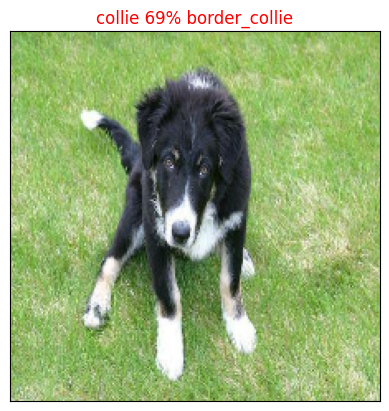

In [ ]:
plot_pred(prediction_probabilities=predictions,
          labels = val_labels,
          images = val_images,
          n=9)

Now we've got one function to visualize our  models top prediction, let's make another to view out models top 10 predictions.

This function will:
* Take an input of predictio probabilities array and a ground truth label and an integer✅
* Find the prediction  using `get_pred_label()` ✅
* Find the top 10:
 * Prediction probabilities indexes✅
 * Preddiction probabilities values✅
 * Prediction labels✅
* Plot the top 10 prediction probability values and labels, colouring the truth label green ✅

In [ ]:
def plot_pred_conf(prediction_probabilities, labels, n):
  """
  Plots the top 10 highest prediction confidences along with the truth label for sample n.
  """
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the top 10 prediction confidense indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]

  # Find the top 10 prediction confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]

  # Find the top 10 prediction labels
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]

  # Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_values,
                     color = "grey")

  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels = top_10_pred_labels,
             rotation = "vertical")

  # Change the colour of true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass


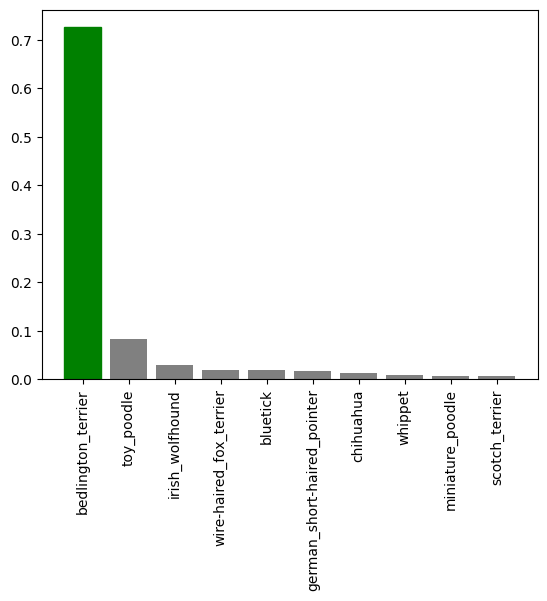

In [ ]:
plot_pred_conf(prediction_probabilities=predictions,
               labels = val_labels,
               n = 54)

In [ ]:
predictions[0]

array([2.3323307e-03, 1.4351885e-04, 1.5960230e-03, 4.0613366e-05,
       2.3384753e-04, 2.3148558e-04, 6.0024809e-02, 2.3006821e-04,
       5.9366106e-05, 3.6384500e-04, 5.7703361e-04, 3.7427223e-04,
       1.3209016e-04, 7.3472111e-05, 1.5877941e-04, 6.2758476e-04,
       1.5374251e-05, 1.4747034e-01, 3.3000553e-05, 8.3741026e-05,
       6.0366723e-04, 2.1531276e-04, 1.8979286e-05, 4.9911125e-04,
       6.3064123e-05, 3.4766673e-04, 2.2310114e-01, 2.8664074e-04,
       1.6805741e-04, 8.7790308e-05, 3.7806170e-05, 2.7161816e-03,
       2.9265197e-04, 2.0542631e-05, 3.1127795e-05, 8.4102049e-02,
       7.0941319e-06, 4.6019765e-04, 3.3680612e-05, 6.4502720e-04,
       7.7460607e-04, 6.2255625e-05, 1.1809181e-05, 3.1099893e-04,
       1.4921200e-05, 2.2060465e-04, 3.6638423e-05, 7.0271950e-04,
       3.5426244e-03, 5.8735608e-05, 7.4974574e-05, 1.2435875e-05,
       2.7787610e-04, 1.3711919e-04, 2.8433011e-05, 1.6332243e-04,
       1.1918617e-04, 2.3871553e-03, 1.1346986e-03, 8.3381273e

In [ ]:
predictions[0].argsort()

array([ 36,  63, 115,  42,  51,  44,  16,  92,  22,  33,  84,  94,  54,
        34,  18,  38, 112,  46,  30, 118,   3,  99, 107,  86,  49,   8,
        41,  24,  72,  71,  13,  50,  19,  64,  29,  91,  75,  56, 117,
        95,  12, 113,  53, 105,   1, 108,  14,  55,  28,  87,  61,  69,
       101,  21,  66,  45,  60,   7,  67,   5,   4, 104,  52,  27,  32,
        88,  43,  82,  25,  85,   9,  11,  78,  80,  37,  23,  96, 114,
        10,  20,  15,  39, 111,  47,  74, 110,  40,  98,  89,  58, 116,
         2, 119,  90,   0,  93,  57,  62,  31,  68,  48,  81,  77,  76,
        97,  83, 100, 106,  79, 102, 109,  65, 103,  70,   6,  73,  59,
        35,  17,  26])

In [ ]:
predictions[0].argsort()[-10:]

array([109,  65, 103,  70,   6,  73,  59,  35,  17,  26])

In [ ]:
predictions[0] [predictions[0].argsort()[-10:][::-1]]


array([0.22310114, 0.14747034, 0.08410205, 0.08338127, 0.06821764,
       0.06002481, 0.05549763, 0.05503499, 0.05332466, 0.02785628],
      dtype=float32)

In [ ]:
predictions[0].max()

0.22310114

In [ ]:
unique_breeds[predictions[0].argsort()[-10:]]

array(['tibetan_terrier', 'komondor', 'soft-coated_wheaten_terrier',
       'lhasa', 'australian_terrier', 'maltese_dog', 'irish_wolfhound',
       'dandie_dinmont', 'border_terrier', 'cairn'], dtype=object)

Now we've got some function to visualize our predictions and evaluate our model, lets check out a few.

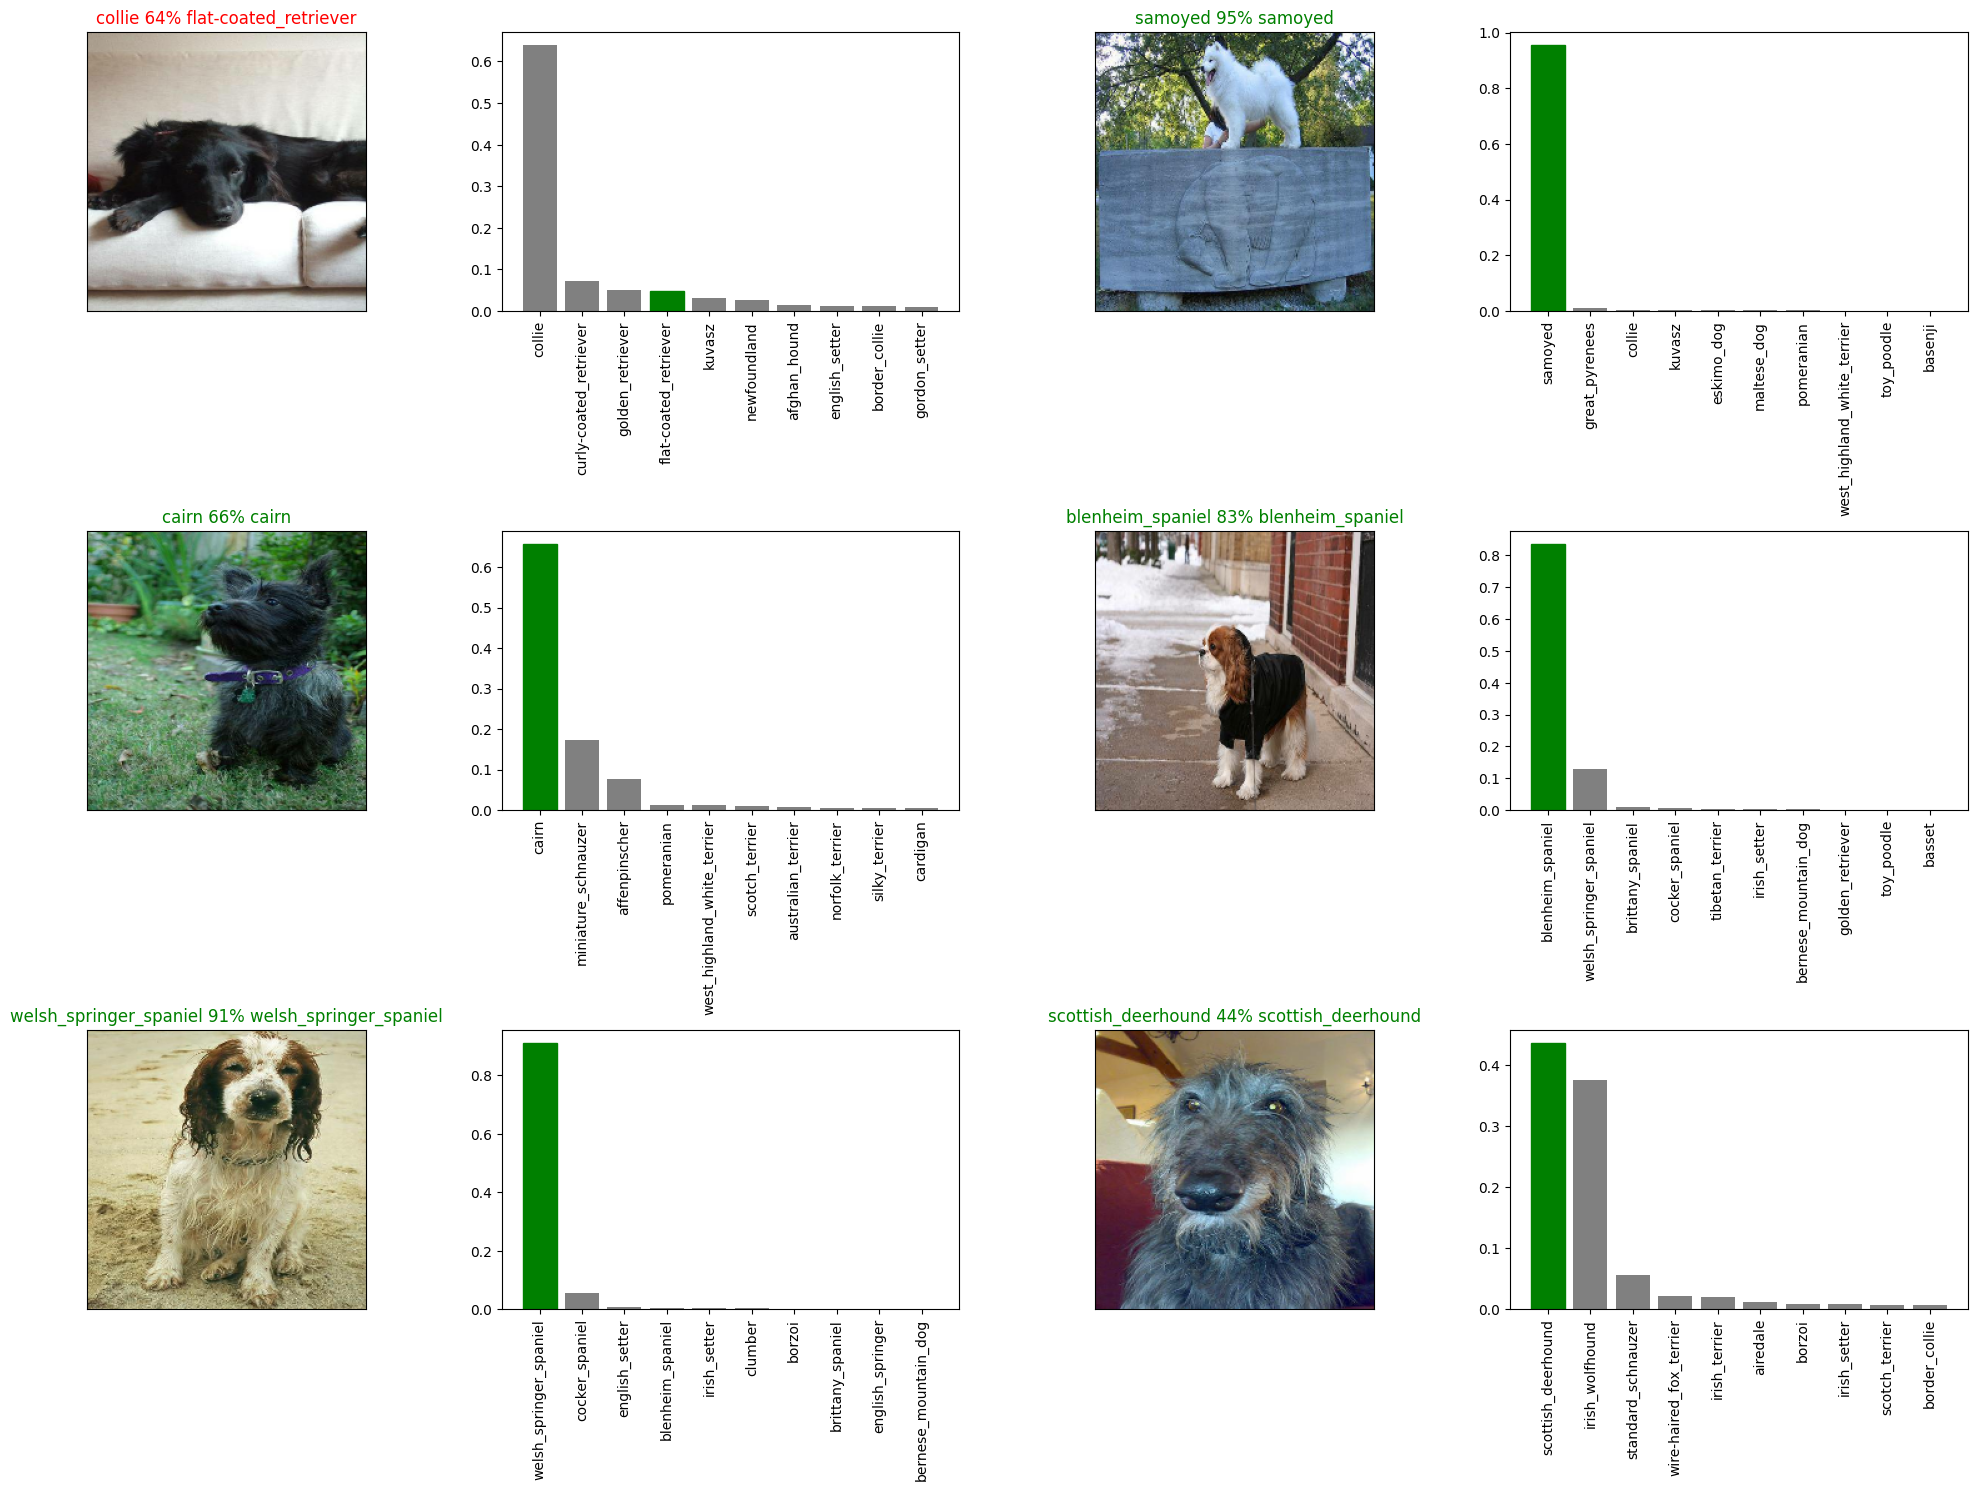

In [ ]:
# Lets check out a few predictions and their different values
i_multiplier = 20
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize = (10*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=predictions,
            labels = val_labels,
            images = val_images,
            n = i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=predictions,
                 labels = val_labels,
                 n = i+i_multiplier)

plt.tight_layout()
plt.show()

**Challenge:** How would you create a confusion matrix with our models predictions and true  labels?

In [ ]:
# import tensorflow_addons as tfa
# def confusion_mat(prediction_probabilities, labels, n):
#   pred_prob, true_label = prediction_probabilities[n], labels[n]

#   metric = tfa.metrics.MultiLabelConfusionMatrix(num_classes=3)
#   metric.update_state(true_label, pred_prob)
#   result = metric.result()
#   return result.numpy()

## Saving and reloading a trained model

In [ ]:
# Create a function to save a model
def save_model(model, suffix = None):
  """
  Saves a given model in a models directory and appends a suffix (string).
  """
  # Create a model directory pathname with current time
  modeldir = os.path.join("drive/MyDrive/Dog Vision/models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  model_path = modeldir + "-" + suffix + ".h5" # Save model format

  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

In [ ]:
# Create a function to load a trained model
def load_model(model_path):
  """
  Loads a saved model from a specified path
  """
  print(f"Loading saved model from: {model_path}...")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects = {"KerasLayer":hub.KerasLayer})
  return model

Now we've got functions to save and load a trained model, let's make sure they work

In [ ]:
# Save out model trained on 1000 images
save_model(model, suffix = "1000-images-mbilenetv2-Adam")

Saving model to: drive/MyDrive/Dog Vision/models/20230827-100417-1000-images-mbilenetv2-Adam.h5...


'drive/MyDrive/Dog Vision/models/20230827-100417-1000-images-mbilenetv2-Adam.h5'

In [ ]:
# Load a trained model
loaded_1000_image_model = load_model("drive/MyDrive/Dog Vision/models/20230826-124848-1000-images-mbilenetv2-Adam.h5")
loaded_1000_image_model

Loading saved model from: drive/MyDrive/Dog Vision/models/20230826-124848-1000-images-mbilenetv2-Adam.h5...


In [ ]:
# Evaluate the pre-loaded model
model.evaluate(val_data)

7/7 [==============================] - 1s 84ms/step - loss: 1.1623 - accuracy: 0.7050


[1.1622645854949951, 0.7049999833106995]

In [ ]:
# Evaluate the loaded model
loaded_1000_image_model.evaluate(val_data)

7/7 [==============================] - 2s 91ms/step - loss: 1.3305 - accuracy: 0.6400


[1.330535888671875, 0.6399999856948853]

# Training a big dog model 🐶 (on the full data)

In [ ]:
len(X), len(y)

(10222, 10222)

In [ ]:
# Create a data batch with the full data set
full_data = create_data_batches(X, y)

Creating training data batches....


In [ ]:
full_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [ ]:
# Create a model for full model
full_model = create_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5


In [ ]:
# Create ful model callbacks
full_model_tensorboard = create_tensorboard_callback()
# No validation set when training on all the data, so we can't monitor validation accuracy
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                            patience=3)

***Note:*** Running the cell below will take a little while (maybe up to 30 minutes for the first epoch) because the GPU we're using in the runtime has to load all the images into memory.

In [ ]:
# Fit the full model to the full data
full_model.fit(x = full_data,
               epochs = NUM_EPOCHS,
               callbacks = [full_model_tensorboard, full_model_early_stopping])

Epoch 1/100
320/320 [==============================] - 40s 112ms/step - loss: 1.3279 - accuracy: 0.6716
Epoch 2/100
320/320 [==============================] - 34s 106ms/step - loss: 0.3993 - accuracy: 0.8842
Epoch 3/100
320/320 [==============================] - 36s 112ms/step - loss: 0.2392 - accuracy: 0.9348
Epoch 4/100
320/320 [==============================] - 34s 107ms/step - loss: 0.1524 - accuracy: 0.9623
Epoch 5/100
320/320 [==============================] - 35s 111ms/step - loss: 0.1061 - accuracy: 0.9795
Epoch 6/100
320/320 [==============================] - 35s 109ms/step - loss: 0.0778 - accuracy: 0.9861
Epoch 7/100
320/320 [==============================] - 35s 110ms/step - loss: 0.0606 - accuracy: 0.9905
Epoch 8/100
320/320 [==============================] - 45s 142ms/step - loss: 0.0460 - accuracy: 0.9943
Epoch 9/100
320/320 [==============================] - 40s 125ms/step - loss: 0.0376 - accuracy: 0.9960
Epoch 10/100
320/320 [==============================] - 34s 107m

In [ ]:
save_model(full_model, suffix = "full-image-set-mobilenettv2-Adam")

Saving model to: drive/MyDrive/Dog Vision/models/20230827-103744-full-image-set-mobilenettv2-Adam.h5...


'drive/MyDrive/Dog Vision/models/20230827-103744-full-image-set-mobilenettv2-Adam.h5'

In [103]:
# Loading full model
loaded_full_model = load_model("drive/MyDrive/Dog Vision/models/20230827-103744-full-image-set-mobilenettv2-Adam.h5")

Loading saved model from: drive/MyDrive/Dog Vision/models/20230827-103744-full-image-set-mobilenettv2-Adam.h5...


In [104]:
len(X)

10222

In [ ]:
len(full_data)

320

## Making predictions on test data set

Since our model has been trained on images in the form of Tensor batches, to make predictions on the test data, we'll have to get it into the same format.

Lockily, we created `create_data_battches()` earlier which can take a list of filenames as input and convert them into Tensor batches.

To make predictions on the test data, we'll:
 * Get the test image filenames.✅
 * Convert the filenames into test data batches using `create_data_batches()` and setting the `test_data` parameter to `True` (since the test data doesn't have labels).✅
 * Make predictions array by passing the test batches to the `predict()` method calledd on out model.

In [163]:
# Load test image filenames
test_path = "drive/MyDrive/Dog Vision/test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]
len(test_filenames), test_filenames[:10]

(10357,
 ['drive/MyDrive/Dog Vision/test/e6a0eeb3e82e14eb812d9ef22383ec11.jpg',
  'drive/MyDrive/Dog Vision/test/e1e7949f64ff3283a5dafa9d39199193.jpg',
  'drive/MyDrive/Dog Vision/test/e0e47873420b2ed420e920a74c663233.jpg',
  'drive/MyDrive/Dog Vision/test/dfe25675d32a75ade0f2893cf2ab63a9.jpg',
  'drive/MyDrive/Dog Vision/test/e35b90290702042d17ceee2aaf2d1475.jpg',
  'drive/MyDrive/Dog Vision/test/e4d878f113883a3caab47d3126d2c2a4.jpg',
  'drive/MyDrive/Dog Vision/test/e01a1ea716359e2f0062aca591ff9ca4.jpg',
  'drive/MyDrive/Dog Vision/test/e6ec1891d8f52a13683c73cabd3045cb.jpg',
  'drive/MyDrive/Dog Vision/test/dd703c7beeaf5cba5533d5f42b608f2e.jpg',
  'drive/MyDrive/Dog Vision/test/e487437a727b3e4f0b919c878d39ae6e.jpg'])

In [164]:
# Create test data batches
test_data = create_data_batches(test_filenames, test_data = True)

Creating test data batches....


In [165]:
len(test_data)

324

In [166]:
test_data

<_BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

***Note:*** callinf `predict()` on our full model and passing it the test data batch will take a long time to run (about an ~1hr)

In [167]:
# Make predictions on test data batch using the loaded full model
test_predictions = loaded_full_model.predict(test_data,
                                                   verbose = 1)

324/324 [==============================] - 39s 121ms/step


In [168]:
# Save predictions (Numpy array) to csv file( for access later)
np.savetxt("drive/MyDrive/Dog Vision/preds_array.csv", test_predictions, delimiter=",")

In [170]:
# Load predictions (Numpy array) from csv file
test_predictions = np.loadtxt("drive/MyDrive/Dog Vision/preds_array.csv", delimiter=",")

In [171]:
test_predictions[:10]

array([[2.63442566e-08, 2.46197818e-09, 1.86607796e-09, ...,
        2.68804912e-09, 3.44193040e-06, 8.37554879e-08],
       [2.00158952e-11, 5.48215411e-08, 2.02552072e-10, ...,
        1.44969215e-12, 8.08851819e-10, 1.16470222e-09],
       [8.69825079e-15, 6.99958078e-11, 3.53193156e-14, ...,
        1.20963810e-14, 5.90082835e-19, 1.93761023e-14],
       ...,
       [1.22964366e-06, 2.04135486e-10, 2.61234856e-09, ...,
        5.26257757e-08, 9.26978173e-05, 2.28186803e-08],
       [4.37165970e-10, 2.28618873e-07, 1.06506093e-09, ...,
        8.44036840e-09, 1.25215626e-12, 1.13493437e-10],
       [9.99979615e-01, 2.00875232e-12, 1.18881294e-11, ...,
        3.45561660e-14, 2.37740053e-07, 3.17659149e-10]])

In [172]:
test_predictions.shape


(10357, 120)

## Preparing test dataset predictions for Kaggle

Looking at the Kaggle sample submission, we find that it wants our models prediction probability outputs in a DataFame with an ID and a column for each different dog breed.

www.kaggle.com/competitions/dog-breed-identification/overview/evaluation

To get the data in this format, we'll:
* Create a pandas DataFrame with an ID column as well as a column for each dog breed.✅
* Add data to the ID column by extracting the test image ID's from their filepaths.✅
* Add data (the prediction probabilities) to each of the dog breed columns.✅
* Export the DataFrame as a CSV t submit it to Kaggle.✅

In [173]:
# Create  a pandas DataFrame with emmpty columns
preds_df = pd.DataFrame(columns=["id"] + list(unique_breeds))

In [174]:
preds_df

Empty DataFrame
Columns: [id, affenpinscher, afghan_hound, african_hunting_dog, airedale, american_staffordshire_terrier, appenzeller, australian_terrier, basenji, basset, beagle, bedlington_terrier, bernese_mountain_dog, black-and-tan_coonhound, blenheim_spaniel, bloodhound, bluetick, border_collie, border_terrier, borzoi, boston_bull, bouvier_des_flandres, boxer, brabancon_griffon, briard, brittany_spaniel, bull_mastiff, cairn, cardigan, chesapeake_bay_retriever, chihuahua, chow, clumber, cocker_spaniel, collie, curly-coated_retriever, dandie_dinmont, dhole, dingo, doberman, english_foxhound, english_setter, english_springer, entlebucher, eskimo_dog, flat-coated_retriever, french_bulldog, german_shepherd, german_short-haired_pointer, giant_schnauzer, golden_retriever, gordon_setter, great_dane, great_pyrenees, greater_swiss_mountain_dog, groenendael, ibizan_hound, irish_setter, irish_terrier, irish_water_spaniel, irish_wolfhound, italian_greyhound, japanese_spaniel, keeshond, kelpie, kerry_blue_terrier, komondor, kuvasz, labrador_retriever, lakeland_terrier, leonberg, lhasa, malamute, malinois, maltese_dog, mexican_hairless, miniature_pinscher, miniature_poodle, miniature_schnauzer, newfoundland, norfolk_terrier, norwegian_elkhound, norwich_terrier, old_english_sheepdog, otterhound, papillon, pekinese, pembroke, pomeranian, pug, redbone, rhodesian_ridgeback, rottweiler, saint_bernard, saluki, samoyed, schipperke, scotch_terrier, scottish_deerhound, sealyham_terrier, ...]
Index: []

[0 rows x 121 columns]

In [175]:
# Append test image ID's to Predictions DataFrame
test_ids = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df["id"] = test_ids

In [176]:
preds_df.head()

id affenpinscher afghan_hound  \
0  e6a0eeb3e82e14eb812d9ef22383ec11           NaN          NaN   
1  e1e7949f64ff3283a5dafa9d39199193           NaN          NaN   
2  e0e47873420b2ed420e920a74c663233           NaN          NaN   
3  dfe25675d32a75ade0f2893cf2ab63a9           NaN          NaN   
4  e35b90290702042d17ceee2aaf2d1475           NaN          NaN   

  african_hunting_dog airedale american_staffordshire_terrier appenzeller  \
0                 NaN      NaN                            NaN         NaN   
1                 NaN      NaN                            NaN         NaN   
2                 NaN      NaN                            NaN         NaN   
3                 NaN      NaN                            NaN         NaN   
4                 NaN      NaN                            NaN         NaN   

  australian_terrier basenji basset  ... toy_poodle toy_terrier vizsla  \
0                NaN     NaN    NaN  ...        NaN         NaN    NaN   
1                NaN     NaN    NaN  ...        NaN         NaN    NaN   
2                NaN     NaN    NaN  ...        NaN         NaN    NaN   
3                NaN     NaN    NaN  ...        NaN         NaN    NaN   
4                NaN     NaN    NaN  ...        NaN         NaN    NaN   

  walker_hound weimaraner welsh_springer_spaniel west_highland_white_terrier  \
0          NaN        NaN                    NaN                         NaN   
1          NaN        NaN                    NaN                         NaN   
2          NaN        NaN                    NaN                         NaN   
3          NaN        NaN                    NaN                         NaN   
4          NaN        NaN                    NaN                         NaN   

  whippet wire-haired_fox_terrier yorkshire_terrier  
0     NaN                     NaN               NaN  
1     NaN                     NaN               NaN  
2     NaN                     NaN               NaN  
3     NaN                     NaN               NaN  
4     NaN                     NaN               NaN  

[5 rows x 121 columns]

In [177]:
# Add the prediction probabilites to each dog breed column
preds_df[list(unique_breeds)] = test_predictions
preds_df.head()

id  affenpinscher  afghan_hound  \
0  e6a0eeb3e82e14eb812d9ef22383ec11   2.634426e-08  2.461978e-09   
1  e1e7949f64ff3283a5dafa9d39199193   2.001590e-11  5.482154e-08   
2  e0e47873420b2ed420e920a74c663233   8.698251e-15  6.999581e-11   
3  dfe25675d32a75ade0f2893cf2ab63a9   3.356070e-10  3.917449e-08   
4  e35b90290702042d17ceee2aaf2d1475   7.876174e-08  7.332662e-10   

   african_hunting_dog      airedale  american_staffordshire_terrier  \
0         1.866078e-09  1.896031e-10                    5.028189e-08   
1         2.025521e-10  8.503612e-09                    3.735856e-10   
2         3.531932e-14  5.836592e-14                    9.967702e-12   
3         5.164413e-10  7.907516e-09                    7.924814e-10   
4         1.554966e-07  4.029445e-08                    4.276007e-08   

    appenzeller  australian_terrier       basenji        basset  ...  \
0  9.580733e-10        1.262377e-07  2.218409e-08  5.716652e-10  ...   
1  4.871441e-11        2.213511e-09  2.424377e-08  5.259480e-12  ...   
2  3.127714e-15        1.585185e-14  2.124403e-14  1.689211e-14  ...   
3  1.930193e-11        6.528655e-10  3.234529e-09  8.735718e-07  ...   
4  1.332959e-11        1.477515e-05  6.875673e-08  3.503628e-08  ...   

     toy_poodle   toy_terrier        vizsla  walker_hound    weimaraner  \
0  2.756775e-01  3.394872e-06  4.747842e-07  8.603870e-10  6.685388e-08   
1  8.289662e-01  4.575340e-09  1.065078e-06  7.299110e-13  3.190729e-09   
2  5.326429e-16  1.219094e-12  1.231160e-13  8.908330e-11  1.400277e-11   
3  1.379677e-09  1.800535e-11  2.308519e-10  1.648764e-10  8.406763e-11   
4  4.080529e-08  7.897322e-07  1.570365e-09  8.938938e-10  5.347433e-11   

   welsh_springer_spaniel  west_highland_white_terrier       whippet  \
0            1.966724e-09                 1.696117e-06  2.688049e-09   
1            1.970723e-11                 4.738494e-12  1.449692e-12   
2            3.405166e-15                 8.273758e-14  1.209638e-14   
3            7.297006e-10                 4.816208e-09  3.159518e-08   
4            7.220291e-09                 2.726640e-05  6.853620e-09   

   wire-haired_fox_terrier  yorkshire_terrier  
0             3.441930e-06       8.375549e-08  
1             8.088518e-10       1.164702e-09  
2             5.900828e-19       1.937610e-14  
3             1.364760e-06       1.292372e-09  
4             9.607684e-08       1.584055e-06  

[5 rows x 121 columns]

In [178]:
preds_df["affenpinscher"]

0        2.634426e-08
1        2.001590e-11
2        8.698251e-15
3        3.356070e-10
4        7.876174e-08
             ...     
10352    1.908874e-09
10353    1.946528e-07
10354    2.440172e-09
10355    1.891247e-06
10356    3.731553e-04
Name: affenpinscher, Length: 10357, dtype: float64

In [179]:
# Save out predictions dataframe to CSV for submission to Kaggle
preds_df.to_csv("drive/MyDrive/Dog Vision/full_model_predictions_submission_1_mobilenetv2.csv", index = False)

## Making predictions on custom images

To make predictions on custom images, we'll:
* Get the filepaths into data batches using `create_data_batches()` and since our custom images won't have labels, we set the `test_data` parameter to `True`.✅
* Add the custom image data batch to our models `predict()` method.✅
* Convert the prediction output probabilities to prediction labels.✅
* Compare the predicted labels to the custom images.✅


In [156]:
# Get custom image filepaths
custom_path = "drive/MyDrive/Dog Vision/dog-photos/"
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)]
custom_image_paths

['drive/MyDrive/Dog Vision/dog-photos/images.jpg',
 'drive/MyDrive/Dog Vision/dog-photos/download.jpg',
 'drive/MyDrive/Dog Vision/dog-photos/download1.jpg']

In [157]:
# Turn custom images into batch data set
custom_data = create_data_batches(custom_image_paths, test_data = True)
custom_data

Creating test data batches....


<_BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

In [158]:
# Make predictions on custom data
custom_preds = loaded_full_model.predict(custom_data)

1/1 [==============================] - 1s 985ms/step


In [161]:
custom_preds.shape

(3, 120)

In [181]:
# Get custom image prediction labels
custom_preds_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_preds_labels

['irish_wolfhound', 'scottish_deerhound', 'irish_wolfhound']

In [182]:
# Get custom images (our unbatchify() function won't work since there aren't labels...may be we could  fix this later)
custom_images = []
# Lop through unbatched data
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

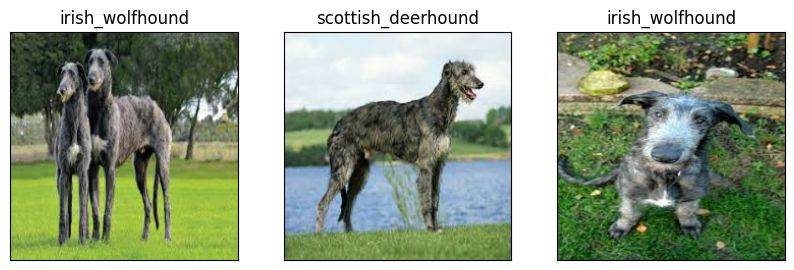

In [183]:
# Check custom image predictions
plt.figure(figsize = (10, 10))
for i, image in enumerate(custom_images):
  plt.subplot(1, 3, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_preds_labels[i])
  plt.imshow(image)